Now that we have had extensive practice with using the `bcs` package to build chimeric PKSs, we can try using the main `RetroTide` package for the biosynthesis of targets given a custom list of starter and extender units. In this notebook, we will focus on attempting to reach only aliphatic targets. For this, we will use the more common, aliphatic starter and extender units.

As a reminder, if we wish to set custom starter and extender units, then we should import `bcs` first and change `bcs.starters` as well as `bcs.extenders` before eventually importing `retrotide` and `structureDB`

In [50]:
import bcs
from typing import Optional, List
from rdkit import Chem
from rdkit.Chem import AllChem

In [51]:
def modify_bcs_starters_extenders(starter_codes: Optional[List[str]] = None, 
                                  extender_codes: Optional[List[str]] = None):
    
    for key in list(bcs.starters.keys()):
        if key not in starter_codes:
            bcs.starters.pop(key, None) # removes key corresponding to the starter code that was not specified
            
    for key in list(bcs.extenders.keys()):
        if key not in extender_codes:
            bcs.extenders.pop(key, None) # same as above but for extenders

Here, we will constrain our list of starter and extender units to malonyl-CoA, methylmalonyl-CoA, hydroxyacetyl-CoA, and allylmalonyl-CoA:

In [52]:
starter_codes = ["Malonyl-CoA", 
                 "Methylmalonyl-CoA", 
                 "Hydroxymalonyl-CoA", 
                 "Allymalonyl-CoA",
                 "mxmal"]

extender_codes = ["Malonyl-CoA",
                  "Methylmalonyl-CoA",
                  "Hydroxymalonyl-CoA",
                  "allylmal",
                  "mxmal"]

In [53]:
modify_bcs_starters_extenders(starter_codes = starter_codes,
                              extender_codes = extender_codes)

Now that we have set the list of starters and extenders, we can import `retrotide` as well as `structureDB`

In [54]:
from retrotide import retrotide, structureDB

Finally, before we begin running RetroTide, let's define a function for releasing the bound PKS product via either a condensation or cyclization reaction catalyzed by the TE domain: 

In [55]:
def _pks_release_reaction(pks_release_mechanism: str, bound_product_mol: Chem.Mol) -> Chem.Mol:
    """
    Run a PKS offloading reaction to release a PKS product bound to its synthase via either a thiolysis or cyclization reaction
    """

    if pks_release_mechanism == 'thiolysis':
        Chem.SanitizeMol(bound_product_mol)  # run detachment reaction to produce terminal acid group
        rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])[S:3]>>[C:1](=[O:2])[O].[S:3]')
        unbound_product_mol = rxn.RunReactants((bound_product_mol,))[0][0]
        Chem.SanitizeMol(unbound_product_mol)
        return unbound_product_mol

    if pks_release_mechanism == 'cyclization':
        Chem.SanitizeMol(bound_product_mol)  # run detachment reaction to cyclize bound substrate
        rxn = AllChem.ReactionFromSmarts('([C:1](=[O:2])[S:3].[O,N:4][C:5][C:6])>>[C:1](=[O:2])[*:4][C:5][C:6].[S:3]')
        try:
            unbound_product_mol = rxn.RunReactants((bound_product_mol,))[0][0]
            Chem.SanitizeMol(unbound_product_mol)
            return unbound_product_mol

        # if the bound substrate cannot be cyclized, then return None
        except:
            raise ValueError("\nUnable to perform cyclization reaction")

#### Biosynthesis of 4-hydroxybutyric acid with RetroTide:

computing module 1
   testing 128 designs
   best score is 0.7142857142857143
computing module 2
   testing 800 designs
   best score is 0.6666666666666666
PKS design: [["AT{'substrate': 'Hydroxymalonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False']]
score: 0.7142857142857143


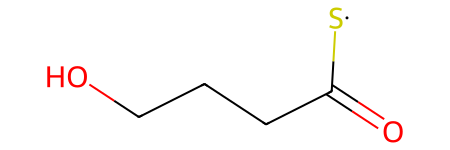

In [56]:
hydroxybutyric_acid_smiles = "C(CC(=O)O)CO"
hydroxybutyric_acid_mol = Chem.MolFromSmiles(hydroxybutyric_acid_smiles)

designs = retrotide.designPKS(targetMol = hydroxybutyric_acid_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

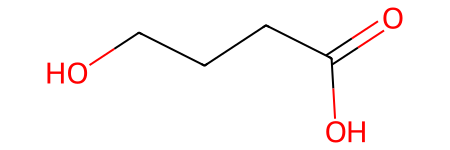

In [57]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of 5-ketohexanoic acid:

computing module 1
   testing 128 designs
   best score is 0.5555555555555556
computing module 2
   testing 800 designs
   best score is 0.7777777777777778
computing module 3
   testing 800 designs
   best score is 0.7272727272727273
PKS design: [["AT{'substrate': 'Malonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", 'loading: False'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False']]
score: 0.7777777777777778


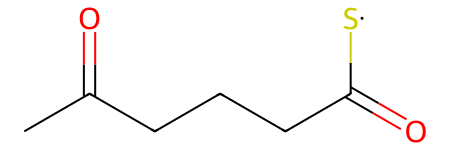

In [58]:
ketohexanoic_acid_smiles = "OC(CCCC(C)=O)=O"
ketohexanoic_acid_mol = Chem.MolFromSmiles(ketohexanoic_acid_smiles)

designs = retrotide.designPKS(targetMol = ketohexanoic_acid_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

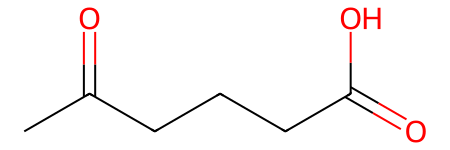

In [59]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of the acrylic acid scaffold

computing module 1
   testing 128 designs
   best score is 0.7142857142857143
computing module 2
   testing 800 designs
   best score is 0.6666666666666666
PKS design: [["AT{'substrate': 'Hydroxymalonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'loading: False']]
score: 0.7142857142857143


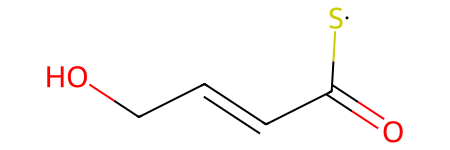

In [60]:
acrylic_acid_scaff_smiles = "OC(/C=C/CO)=O"
acrylic_acid_scaff_mol = Chem.MolFromSmiles(acrylic_acid_scaff_smiles)

designs = retrotide.designPKS(targetMol = acrylic_acid_scaff_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

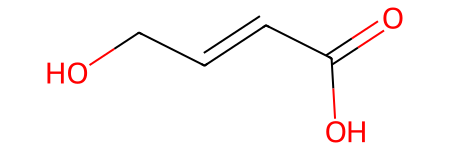

In [61]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of the levulinic acid scaffold

computing module 1
   testing 128 designs
   best score is 0.6
computing module 2
   testing 800 designs
   best score is 0.8
computing module 3
   testing 800 designs
   best score is 0.6666666666666666
PKS design: [["AT{'substrate': 'Hydroxymalonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'A'}", 'loading: False'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False']]
score: 0.8


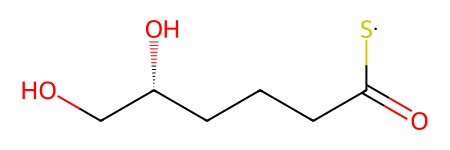

In [62]:
levulinic_acid_scaff_smiles = "CC(CCC(C(O)=O)O)=O"
levulinic_acid_scaff_mol = Chem.MolFromSmiles(levulinic_acid_scaff_smiles)

designs = retrotide.designPKS(targetMol = levulinic_acid_scaff_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

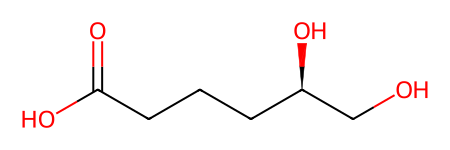

In [63]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of tiglic acid

computing module 1
   testing 128 designs
   best score is 0.7142857142857143
computing module 2
   testing 800 designs
   best score is 0.6666666666666666
PKS design: [["AT{'substrate': 'Malonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'B1'}", 'DH{}', 'loading: False']]
score: 0.7142857142857143


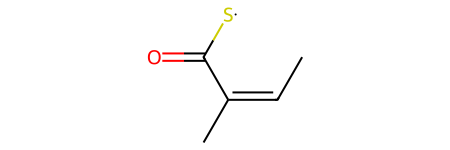

In [64]:
tiglic_acid_smiles = "C/C=C(C(O)=O)\C"
tiglic_acid_mol = Chem.MolFromSmiles(tiglic_acid_smiles)

designs = retrotide.designPKS(targetMol = tiglic_acid_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

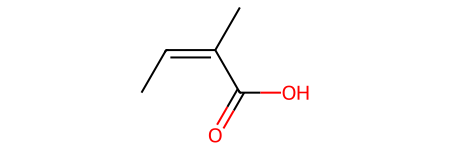

In [65]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of caprolactone

computing module 1
   testing 128 designs
   best score is 0.75
computing module 2
   testing 800 designs
   best score is 0.875
computing module 3
   testing 800 designs
   best score is 0.8
PKS design: [["AT{'substrate': 'Hydroxymalonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False']]
score: 0.875


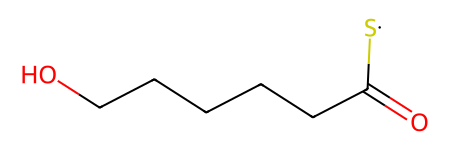

In [66]:
caprolactone_smiles = "C1CCC(=O)OCC1"
caprolactone_mol = Chem.MolFromSmiles(caprolactone_smiles)

designs = retrotide.designPKS(targetMol = caprolactone_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

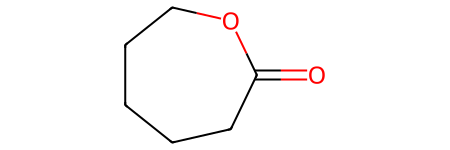

In [67]:
_pks_release_reaction(pks_release_mechanism = 'cyclization', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of gamma-butyrolactone

computing module 1
   testing 128 designs
   best score is 0.8333333333333334
computing module 2
   testing 800 designs
   best score is 0.75
PKS design: [["AT{'substrate': 'Hydroxymalonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False']]
score: 0.8333333333333334


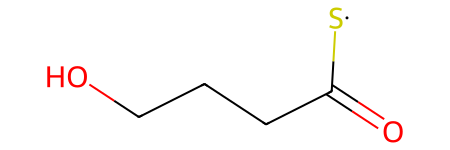

In [68]:
gamma_butyrolactone_smiles = "C1CC(=O)OC1"
gamma_butyrolactone_mol = Chem.MolFromSmiles(gamma_butyrolactone_smiles)

designs = retrotide.designPKS(targetMol = gamma_butyrolactone_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

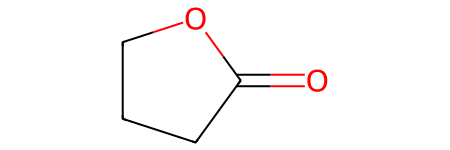

In [69]:
_pks_release_reaction(pks_release_mechanism = 'cyclization', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of the adipic acid scaffold

computing module 1
   testing 128 designs
   best score is 0.5555555555555556
computing module 2
   testing 800 designs
   best score is 0.7777777777777778
computing module 3
   testing 800 designs
   best score is 0.7272727272727273
PKS design: [["AT{'substrate': 'Hydroxymalonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False']]
score: 0.7777777777777778


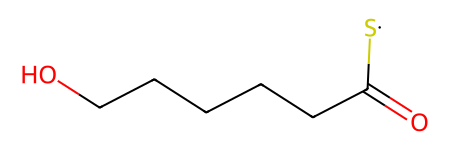

In [70]:
adipic_acid_scaff_smiles = "OCCCCCC(O)=O"
adipic_acid_scaff_mol = Chem.MolFromSmiles(adipic_acid_scaff_smiles)

designs = retrotide.designPKS(targetMol = adipic_acid_scaff_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

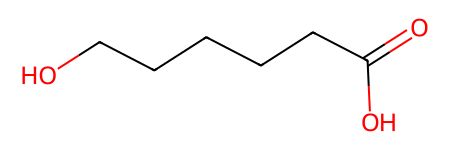

In [71]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of the butanone scaffold

computing module 1
   testing 128 designs
   best score is 0.75
computing module 2
   testing 800 designs
   best score is 0.7
PKS design: [["AT{'substrate': 'Malonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Methylmalonyl-CoA'}", 'loading: False']]
score: 0.75


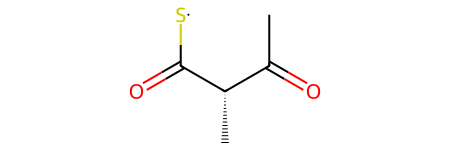

In [72]:
butanone_scaff_smiles = "CC(C(C)C(O)=O)=O"
butanone_scaff_mol = Chem.MolFromSmiles(butanone_scaff_smiles)

designs = retrotide.designPKS(targetMol = butanone_scaff_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

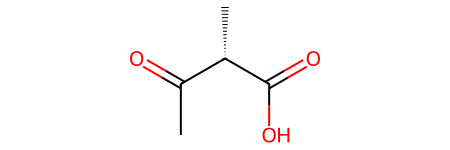

In [73]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of the heptane scaffold

computing module 1
   testing 128 designs
   best score is 0.6666666666666666
computing module 2
   testing 800 designs
   best score is 0.7777777777777778
computing module 3
   testing 800 designs
   best score is 0.6666666666666666
PKS design: [["AT{'substrate': 'Hydroxymalonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False']]
score: 0.7777777777777778


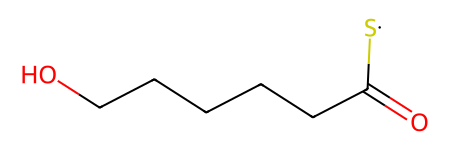

In [74]:
heptane_scaff_smiles = "OC(C(C)CCCC)=O"
heptane_scaff_mol = Chem.MolFromSmiles(heptane_scaff_smiles)

designs = retrotide.designPKS(targetMol = heptane_scaff_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

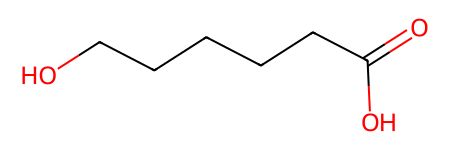

In [75]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of the maleic acid scaffold

computing module 1
   testing 128 designs
   best score is 0.7142857142857143
computing module 2
   testing 800 designs
   best score is 0.6666666666666666
PKS design: [["AT{'substrate': 'Hydroxymalonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'loading: False']]
score: 0.7142857142857143


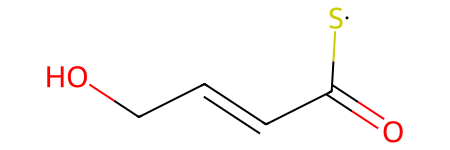

In [76]:
maleic_acid_scaff_smiles = "OC/C=C/C(O)=O"
maleic_acid_scaff_mol = Chem.MolFromSmiles(maleic_acid_scaff_smiles)

designs = retrotide.designPKS(targetMol = maleic_acid_scaff_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

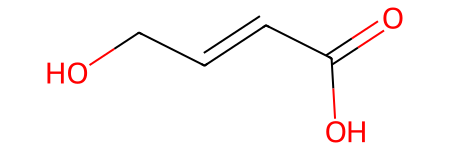

In [77]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of the 1,4-butanediol scaffold

computing module 1
   testing 128 designs
   best score is 0.8333333333333334
computing module 2
   testing 800 designs
   best score is 0.75
PKS design: [["AT{'substrate': 'Hydroxymalonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False']]
score: 0.8333333333333334


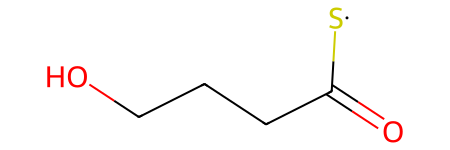

In [78]:
BDO_scaff_smiles = "OCCCCO"
BDO_scaff_mol = Chem.MolFromSmiles(BDO_scaff_smiles)

designs = retrotide.designPKS(targetMol = BDO_scaff_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

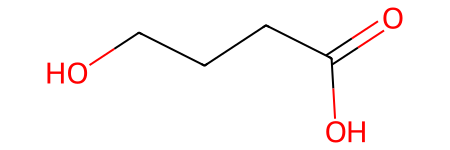

In [79]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)

#### Biosynthesis of the muconic acid scaffold

computing module 1
   testing 128 designs
   best score is 0.5555555555555556
computing module 2
   testing 800 designs
   best score is 0.7777777777777778
computing module 3
   testing 800 designs
   best score is 0.7272727272727273
PKS design: [["AT{'substrate': 'Hydroxymalonyl-CoA'}", 'loading: True'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'loading: False'], ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'loading: False']]
score: 0.7777777777777778


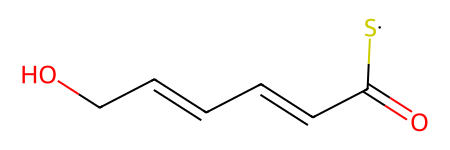

In [80]:
muconic_acid_scaff_smiles = "OC/C=C/C=C/C(O)=O"
muconic_acid_scaff_mol = Chem.MolFromSmiles(muconic_acid_scaff_smiles)

designs = retrotide.designPKS(targetMol = muconic_acid_scaff_mol,
                              similarity = 'mcs_without_stereo')

print('PKS design: ' + repr(designs[-1][0][0].modules))
print('score: ' + str(designs[-1][0][1]))
bound_top_PKS_product = designs[-1][0][0].computeProduct(structureDB)
bound_top_PKS_product

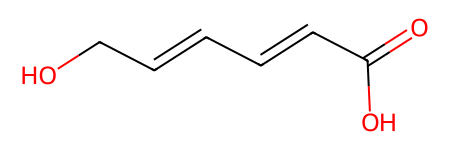

In [81]:
_pks_release_reaction(pks_release_mechanism = 'thiolysis', bound_product_mol = bound_top_PKS_product)